# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# We will use CIFAR-10 as our in-distribution dataset.
# Normalize the images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 32
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

# In case we want to pretty-print classifications.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Invert normalization to print images
class NormalizeInverse(torchvision.transforms.Normalize):
    #Undoes the normalization and returns the reconstructed images in the input domain.
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv_norm = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

Files already downloaded and verified
Files already downloaded and verified


### CNN
Below there is code which defines a CNN model and its training process. It is also possible to load a pre-trained model-

In [3]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Train a model on a given dataloader for epochs. The input images can be adversarially attacked, data augmentation
def training(model, train_dataloader, epochs = 50, adversarial = None, name =""):
  model.train()
  # Train for only 50 epochs.
  epochs = epochs
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Main training loop.
  for epoch in range(epochs):
      running_loss = 0.0
      # Iterate over all batches.
      for (i, (Xs, ys)) in enumerate(train_dataloader, 0):
          Xs = Xs.to(device)
          ys = ys.to(device)
          # Create attacked images and modify the inputs and the labels
          if adversarial is not None:
            xs_attacked, _  = adversarial.attack(Xs, ys, model)
            # Original inputs and attacked inputs
            Xs = torch.cat((Xs, xs_attacked))
            # Both original and attacked inputs have the same labels
            ys = torch.cat((ys,ys))

          # Make a gradient step.
          optimizer.zero_grad()
          outputs = model(Xs)
          loss = criterion(outputs, ys)
          loss.backward()
          optimizer.step()

          # Track epoch loss.
          running_loss += loss.item()

      # Print average epoch loss.
      print(f'{epoch + 1} loss: {running_loss / len(dl_train):.3f}')

  print('Finished Training')
  torch.save(model.state_dict(), './cifar10_CNN'+name+'.pth')

In [90]:
# Pretrained model
model = CNN().to(device)
model.load_state_dict(torch.load('./cifar10_CNN.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [5]:
# USE THIS CELL TO TRAIN MODEL FROM SCRATCH.
model = CNN().to(device)
training(model, dl_train, epochs = 50)

/data01/dl24nicara/DLA/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1 loss: 1.609
2 loss: 1.305
3 loss: 1.176
4 loss: 1.091
5 loss: 1.025
6 loss: 0.972
7 loss: 0.925
8 loss: 0.893
9 loss: 0.858
10 loss: 0.832
11 loss: 0.807
12 loss: 0.781
13 loss: 0.763
14 loss: 0.742
15 loss: 0.721
16 loss: 0.704
17 loss: 0.689
18 loss: 0.669
19 loss: 0.650
20 loss: 0.635
21 loss: 0.624
22 loss: 0.608
23 loss: 0.598
24 loss: 0.584
25 loss: 0.567
26 loss: 0.556
27 loss: 0.549
28 loss: 0.531
29 loss: 0.527
30 loss: 0.521
31 loss: 0.504
32 loss: 0.497
33 loss: 0.488
34 loss: 0.483
35 loss: 0.476
36 loss: 0.458
37 loss: 0.457
38 loss: 0.444
39 loss: 0.444
40 loss: 0.435
41 loss: 0.428
42 loss: 0.422
43 loss: 0.417
44 loss: 0.406
45 loss: 0.410
46 loss: 0.397
47 loss: 0.396
48 loss: 0.390
49 loss: 0.388
50 loss: 0.380
Finished Training


Evaluating the model, the code also generates a Confusion Matrix.

tensor(0.6103, device='cuda:0')


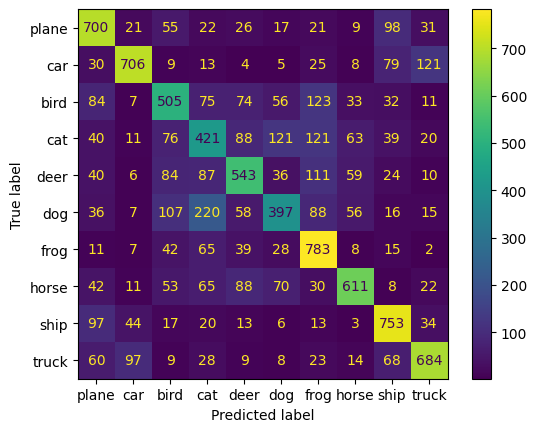

In [6]:
#Test model
model.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    x, y = x.to(device), y.to(device)
    
    yp = model(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

from sklearn import metrics

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

### OOD: Fake dataset and Cifar100 subset

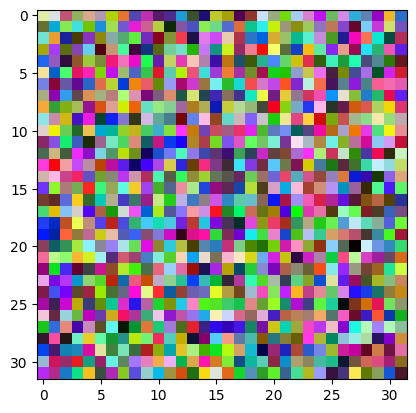

In [7]:
# Fake dataset.
ds_fake = FakeData(size=1000, image_size=(3, 32, 32), transform=transform) #ogni canale è campionato da una gaussiana
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=False, num_workers=2)

# Plot a fake image.
plt.imshow(FakeData(size=1, image_size=(3, 32, 32))[0][0])

Files already downloaded and verified
Cifar100 subset classes: ['bowl', 'chair', 'dolphin', 'lamp', 'otter', 'plain', 'tank', 'train', 'rose', 'bed']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


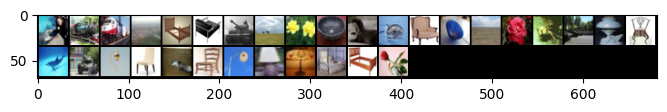

In [8]:
from typing import List

# Takes a list of indices (CIFAR100 classes) and creates a subset
class CIFAR100Subset(CIFAR100):
    def __init__(self, subset: List[int], **kwargs):
        super().__init__(**kwargs)
        self.subset = subset
        # Check indices
        assert max(subset) <= max(self.targets)
        assert min(subset) >= min(self.targets)
        # Selects the classes
        self.aligned_indices = []
        for idx, label in enumerate(self.targets):
            if label in subset:
                self.aligned_indices.append(idx)

    def get_class_names(self):
        return [self.classes[i] for i in self.subset]

    def __len__(self):
        return len(self.aligned_indices)

    def __getitem__(self, item):
        return super().__getitem__(self.aligned_indices[item])

# Get cifar100 subset, OOD dataset
ds_cifar100_subset = CIFAR100Subset(
    subset=[10, 20, 30, 40, 55, 60, 85, 90, 70, 5],
    root='./dataset',
    train=True,
    download=True,
    transform=transform
)

cifar100_sub_classes= ds_cifar100_subset.get_class_names()
print(f'Cifar100 subset classes: {cifar100_sub_classes}')

dl_cifar100 = torch.utils.data.DataLoader(ds_cifar100_subset, batch_size=batch_size, shuffle=True, num_workers=2)
# Showing some images
x, _ = next(iter(dl_cifar100))
grid_img = torchvision.utils.make_grid(inv_norm(x), nrow=20)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compute Scores
Distributions of different scoring functions of logits generated by the model with ID or OOD datasets.

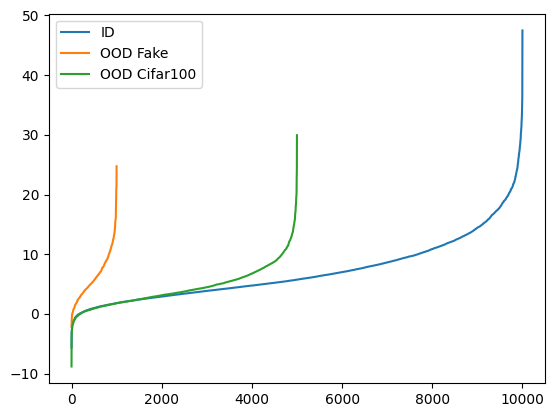

In [9]:
# Max logit
def max_logit(logits):
    s = logits.max(dim=1)[0]
    return s

# Max after softmax
def max_softmax(logits, T=1.0):
    s = F.softmax(logits/T, 1)
    s = s.max(dim=1)[0]
    return s

 # Compute scores and plot results
def compute_scores(model, data_loader, score_fun):
    scores=[]

    for data in data_loader:
        x, y = data
        x, y = x.to(device), y.to(device)
        output = model(x)
        s = score_fun(output)
        scores.append(s)
    
    scores_t = torch.cat(scores)
    return scores_t

# Scores with max_logit
scores_test = compute_scores(model, dl_test, max_logit)
scores_fake = compute_scores(model, dl_fake, max_logit)
scores_fake2 = compute_scores(model, dl_cifar100, max_logit)

plt.plot(sorted(scores_test.detach().cpu()), label='ID')
plt.plot(sorted(scores_fake.detach().cpu()), label='OOD Fake')
plt.plot(sorted(scores_fake2.detach().cpu()), label='OOD Cifar100')
plt.legend()

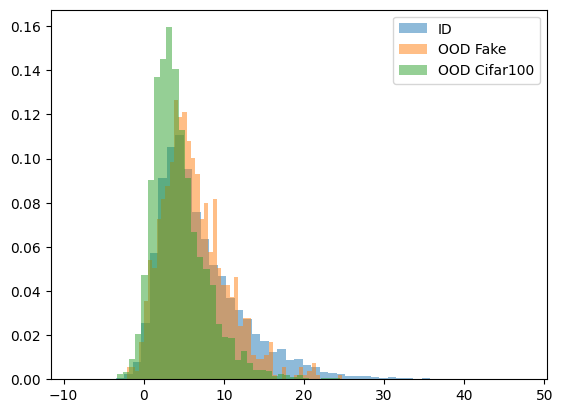

In [10]:
# Plot the *distribution* of max_logit outputs.
_ = plt.hist(scores_test.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_fake2.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

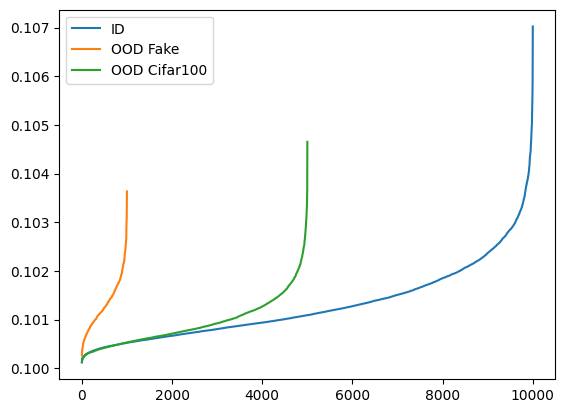

In [11]:
# Scores with max_softamx
temp = 1000
scores_test_ms = compute_scores(model, dl_test, lambda l: max_softmax(l, T=temp))
scores_fake_ms = compute_scores(model, dl_fake, lambda l: max_softmax(l, T=temp))
scores_fake2_ms = compute_scores(model, dl_cifar100, lambda l: max_softmax(l, T=temp))

plt.plot(sorted(scores_test_ms.detach().cpu()), label='ID')
plt.plot(sorted(scores_fake_ms.detach().cpu()), label='OOD Fake')
plt.plot(sorted(scores_fake2_ms.detach().cpu()), label='OOD Cifar100')
plt.legend()

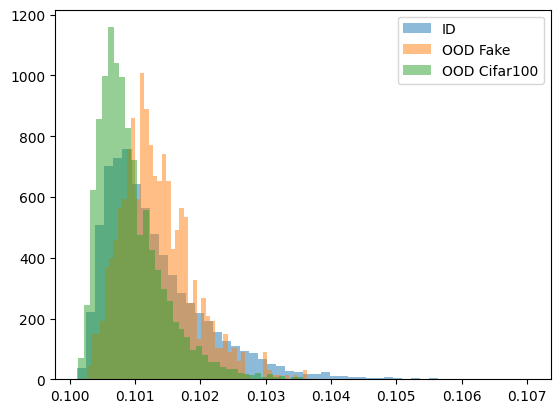

In [12]:
# Plot the *distribution* of max_softmax outputs.
_ = plt.hist(scores_test_ms.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_ms.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_fake2_ms.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


### ROC Curve
The ROC curve shows the relationship between the true positive rate (TPR) and the false positive rate (FPR) for the model.

The following function plot plots the ROC curve between scores (max logit or softmax) and the ground truths (from ID and OOD datasets). The plot also highlights the area under the ROC curve (AUC), which represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative.

In [13]:
def ROC(scores_id, scores_ood):
  ypred = torch.cat((scores_id, scores_ood))
  y_id = torch.ones_like(scores_id)
  y_ood = torch.zeros_like(scores_ood)
  y_true = torch.cat((y_id, y_ood))
  # ROC curve given true labels and predicted label
  metrics.RocCurveDisplay.from_predictions(y_true.cpu(), ypred.cpu())

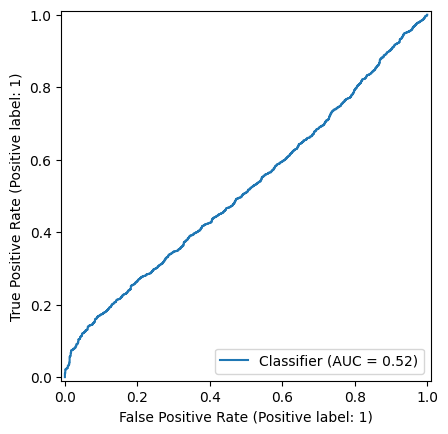

In [14]:
# Cifar10 and FAKE Data, max_logit
ROC(scores_test.detach().cpu(), scores_fake.detach().cpu())

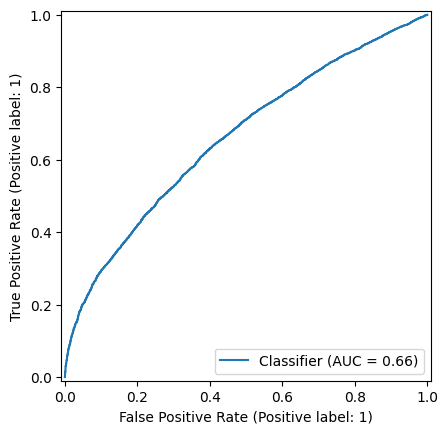

In [15]:
# Cifar10 and subset of Cifar100, max_logit
ROC(scores_test.detach().cpu(), scores_fake2.detach().cpu())

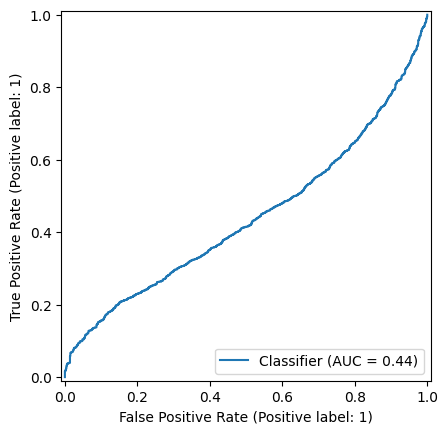

In [16]:
# Cifar10 and FAKE Data, max_softmax
ROC(scores_test_ms.detach().cpu(), scores_fake_ms.detach().cpu())

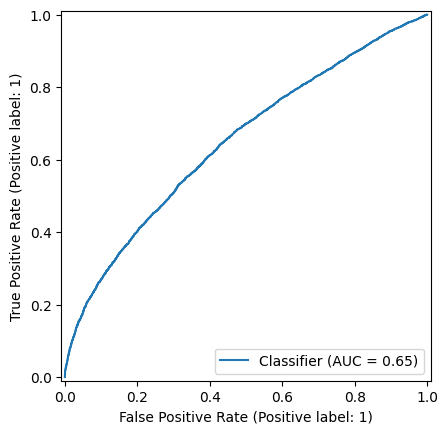

In [17]:
# Cifar10 and subset of Cifar100, max_softmax
ROC(scores_test_ms.detach().cpu(), scores_fake2_ms.detach().cpu())

Add comments

### PR Curve
The PR (precision-recall) Curve shows the tradeoff between Precision (P=TP/(TP+FP)) and Recall (R=TP/(TP+FN)).

The following function plot plots the PR curve between scores (max logit or softmax) and the ground truths (from ID and OOD datasets). The plot also shows the average precision (AP).

In [18]:
def PR(scores_id, scores_ood):
  ypred = torch.cat((scores_id, scores_ood))
  y_id = torch.ones_like(scores_id)
  y_ood = torch.zeros_like(scores_ood)
  y_true = torch.cat((y_id, y_ood))
  # Precision Recall curve given true labels and predicted label
  metrics.PrecisionRecallDisplay.from_predictions(y_true.detach().cpu(), ypred.detach().cpu())

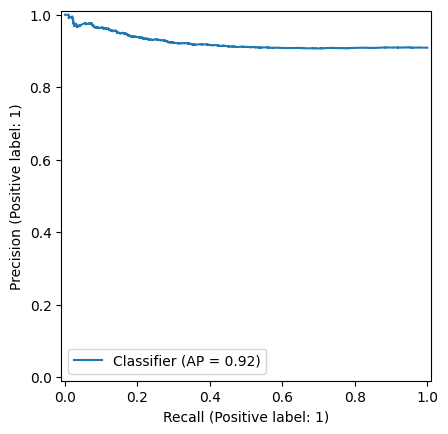

In [19]:
# Cifar10 and FAKE Data, max_logit
PR(scores_test.detach().cpu(), scores_fake.detach().cpu())

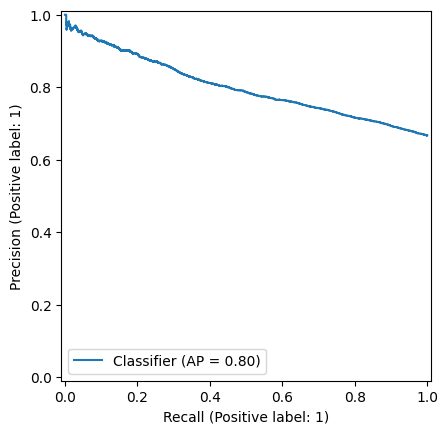

In [20]:
# Cifar10 and subset of Cifar100, max_logit
PR(scores_test.detach().cpu(), scores_fake2.detach().cpu())

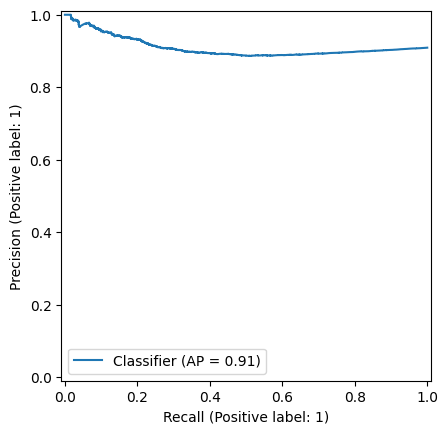

In [21]:
# Cifar10 and FAKE Data, max_softmax
PR(scores_test_ms.detach().cpu(), scores_fake_ms.detach().cpu())

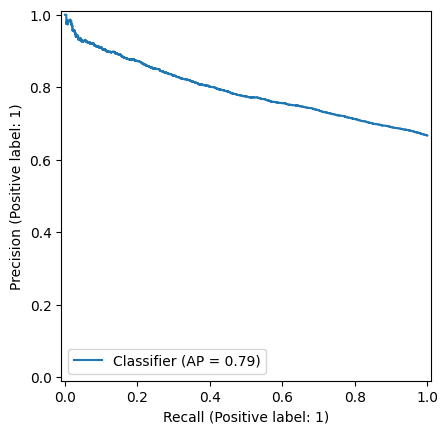

In [22]:
# Cifar 10 and subset of Cifar100, max_softmax
PR(scores_test_ms.detach().cpu(), scores_fake2_ms.detach().cpu())

Add comments

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [23]:
# Implementation of FGSM on a batch of images (and their labels) given a model, epsilon and
# the number of steps (how many "adversarial steps" to take)
class FGSM:
  def __init__(self, epsilon, num_steps = 5):
    self.epsilon = epsilon
    self.num_steps = num_steps

  def attack(self, images, labels, model):
    model.train()
    # Don't modify original images or labels
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    loss = nn.CrossEntropyLoss()
    # To calculate gradient
    images.requires_grad = True
    for _ in range(self.num_steps):
      # To make grad calculation possible
      images.retain_grad()

      outputs = model(images)
      # Calculate loss
      cost = loss(outputs, labels)

      # Computes and returns the sum of gradients of outputs with respect to the inputs.
      grad = torch.autograd.grad(cost, images, retain_graph=False)[0]

      # Update adversarial images
      images = images + self.epsilon * grad.sign()
    model.eval()
    return images, outputs

# Show the changes between an image and the same image after the adversarial attack
def Compare_img(image, first_out, adv_image, output):
  # Show the original image and its predicted class
  print(f'Original image and original predicted class')
  img = inv_norm(image)
  plt.imshow(img.permute(1,2,0))
  plt.title(classes[first_out.argmax()])
  plt.show()

  print(f'Image and predicted class after the adversarial attack')
  # Show the image and its predicted class after the adversarial attack
  img_adv = inv_norm(adv_image)
  plt.imshow(img_adv.permute(1,2,0).detach().cpu())
  plt.title(classes[output.argmax()])
  plt.show()

  print(f'Absolute difference between the two images')
  # Computes the absolute value of the difference between the two images and shows it
  diff = torch.abs(adv_image.detach().cpu()-image)
  diff_inv = inv_norm(diff)
  plt.imshow(diff_inv.permute(1,2,0))
  plt.title('diff')
  plt.show()
  print(f'Histogram with the difference of the two images on a pixel level')
  # Show an histogram with the difference between the two images on a pixel level
  diff_flat = diff.flatten()
  plt.hist(diff_flat)

### epsilon = 0.002

Original image and original predicted class


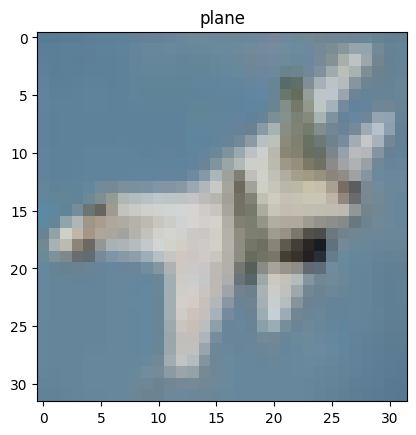

Image and predicted class after the adversarial attack


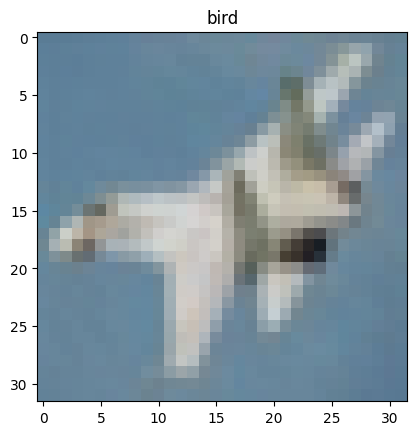

Absolute difference between the two images


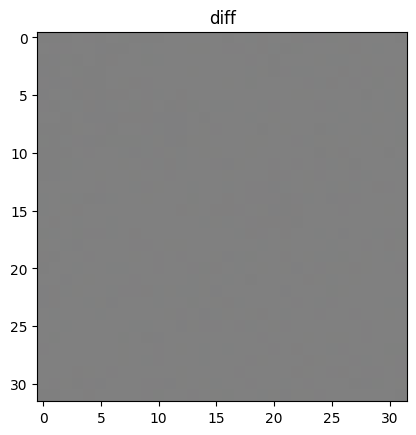

Histogram with the difference of the two images on a pixel level


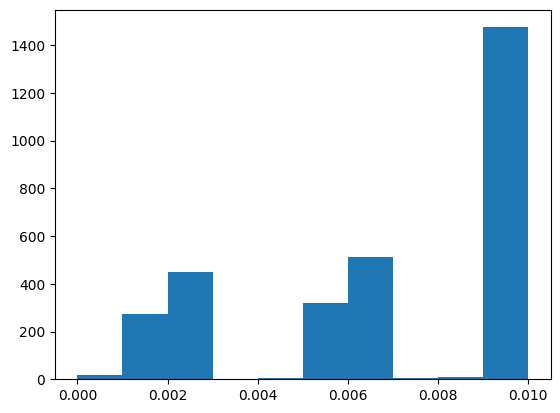

In [24]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Get some test images
for data in dl_test:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Add comments

### epsilon = 0.008

Original image and original predicted class


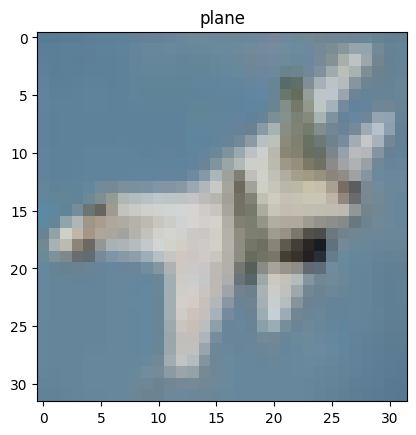

Image and predicted class after the adversarial attack


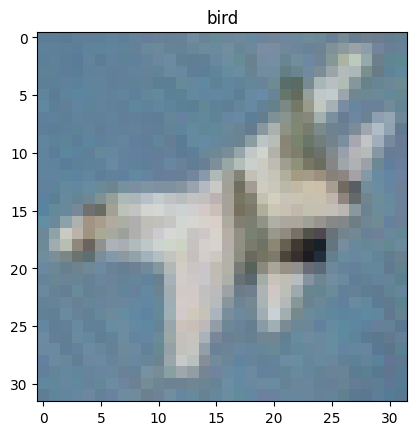

Absolute difference between the two images


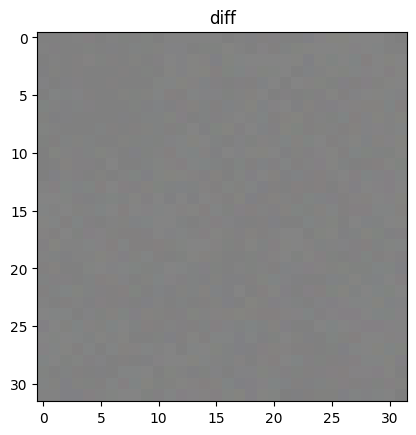

Histogram with the difference of the two images on a pixel level


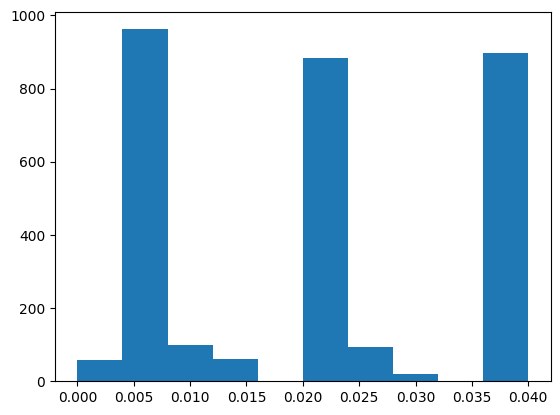

In [25]:
#Bigger epsilon
eps = 0.008

# Get some test images
for data in dl_test:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Add comments

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

 ### epsilon = 0.002
I attacked the training images and concatenated them to the original images, while training from scratch a CNN with the same architecture used before. I decided to use the attack with epsilon = 0.002, since it's less evidet to a human eye.

In [26]:
# Define epsilon, FGSM and model
eps = 0.002
fgsm = FGSM(epsilon = eps, num_steps = 5)
model_adv = CNN().to(device)

# Load pretrained model
model_adv.load_state_dict(torch.load('./cifar10_CNN_adversarial2.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [27]:
# Define epsilon, FGSM and model
eps = 0.002
fgsm = FGSM(epsilon = eps, num_steps = 5)
model_adv = CNN().to(device)

# Train the model from scratch whith adversarial samples
training(model_adv, dl_train, epochs = 50, adversarial =fgsm, name = "_adversarial2")

1 loss: 1.681
2 loss: 1.446
3 loss: 1.350
4 loss: 1.286
5 loss: 1.242
6 loss: 1.206
7 loss: 1.176
8 loss: 1.147
9 loss: 1.127
10 loss: 1.104
11 loss: 1.083
12 loss: 1.066
13 loss: 1.050
14 loss: 1.037
15 loss: 1.020
16 loss: 1.009
17 loss: 0.997
18 loss: 0.989
19 loss: 0.977
20 loss: 0.966
21 loss: 0.961
22 loss: 0.954
23 loss: 0.945
24 loss: 0.938
25 loss: 0.930
26 loss: 0.922
27 loss: 0.919
28 loss: 0.913
29 loss: 0.905
30 loss: 0.900
31 loss: 0.894
32 loss: 0.891
33 loss: 0.885
34 loss: 0.882
35 loss: 0.878
36 loss: 0.872
37 loss: 0.865
38 loss: 0.864
39 loss: 0.861
40 loss: 0.859
41 loss: 0.854
42 loss: 0.849
43 loss: 0.848
44 loss: 0.844
45 loss: 0.840
46 loss: 0.838
47 loss: 0.834
48 loss: 0.831
49 loss: 0.826
50 loss: 0.822
Finished Training


tensor(0.6248, device='cuda:0')


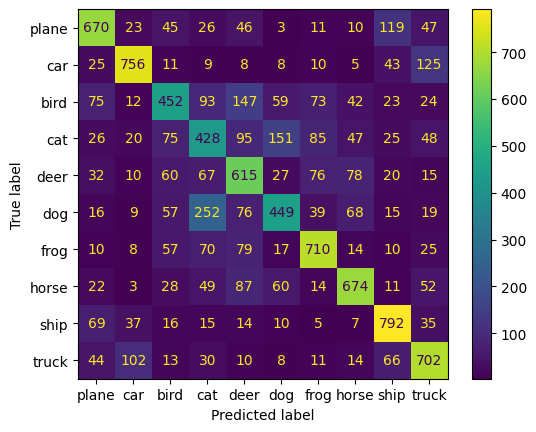

In [27]:
# Test the model on regular test images
model_adv.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    x, y = x.to(device), y.to(device)
    
    yp = model_adv(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Add comments, refer to the original model

### Compute scores

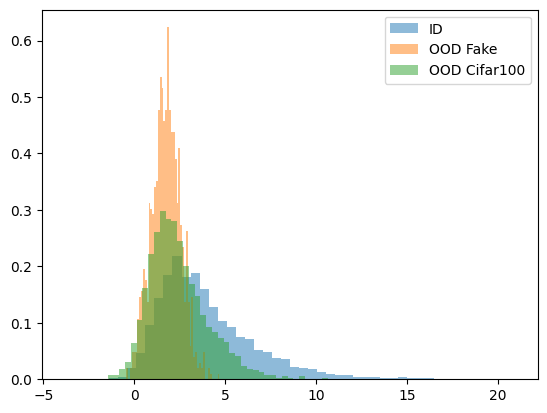

In [28]:
# Scores with max logit
scores_test_adv = compute_scores(model_adv, dl_test, max_logit)
scores_fake_adv = compute_scores(model_adv, dl_fake, max_logit)
scores_fake2_adv = compute_scores(model_adv, dl_cifar100, max_logit)
_ = plt.hist(scores_test_adv.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_fake2_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

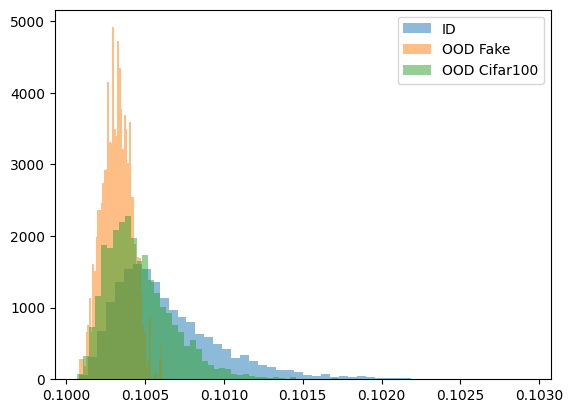

In [29]:
# Scores with max softmax
temp = 1000
scores_test_ms_adv = compute_scores(model_adv, dl_test, lambda l: max_softmax(l, T=temp))
scores_fake_ms_adv = compute_scores(model_adv, dl_fake, lambda l: max_softmax(l, T=temp))
scores_fake2_ms_adv = compute_scores(model_adv, dl_cifar100, lambda l: max_softmax(l, T=temp))
_ = plt.hist(scores_test_ms_adv.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_ms_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_fake2_ms_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

Add comments

### ROC Curve

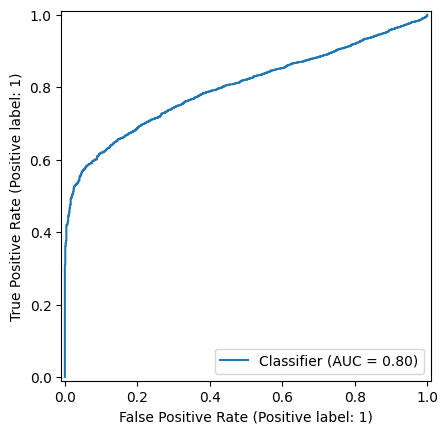

In [30]:
# Cifar10 and FAKE data, max_logit
ROC(scores_test_adv.detach().cpu(), scores_fake_adv.detach().cpu())

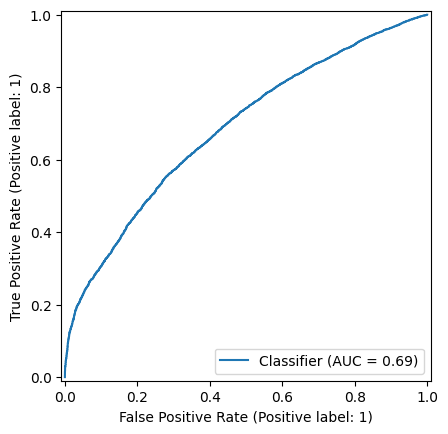

In [31]:
# Cifar10 and subset of Cifar100, max_logit
ROC(scores_test_adv.detach().cpu(), scores_fake2_adv.detach().cpu())

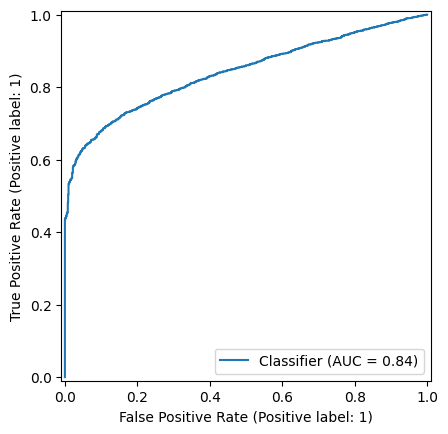

In [32]:
# Cifar10 and FAKE Data, max_softmax
ROC(scores_test_ms_adv.detach().cpu(), scores_fake_ms_adv.detach().cpu())

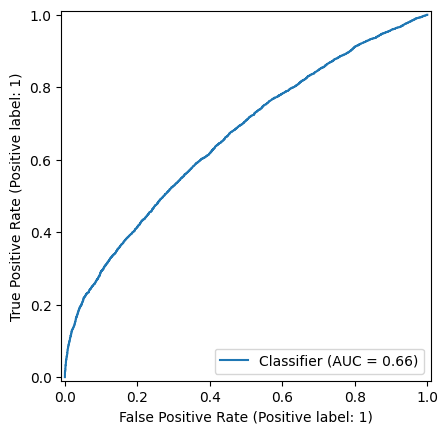

In [33]:
# Cifar10 and subset od Cifar100, max_softmax
ROC(scores_test_ms_adv.detach().cpu(), scores_fake2_ms_adv.detach().cpu())

Add Comments

### PR Curve

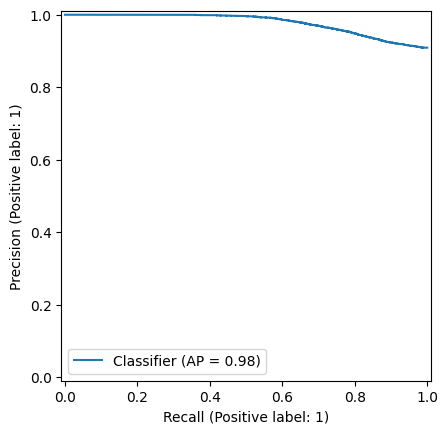

In [34]:
# Cifar10 and FAKE Data, max_logit
PR(scores_test_adv.detach().cpu(), scores_fake_adv.detach().cpu())

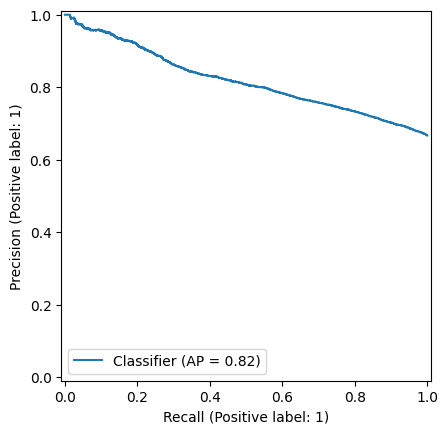

In [35]:
# Cifar10 and subset of Cifar100, max_logit
PR(scores_test_adv.detach().cpu(), scores_fake2_adv.detach().cpu())

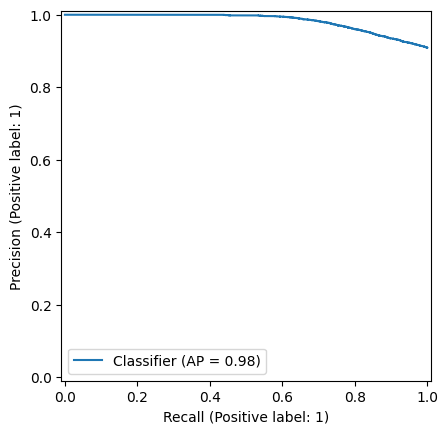

In [36]:
# Cifar10 and FAKE Data, max_softmax
PR(scores_test_ms_adv.detach().cpu(), scores_fake_ms_adv.detach().cpu())

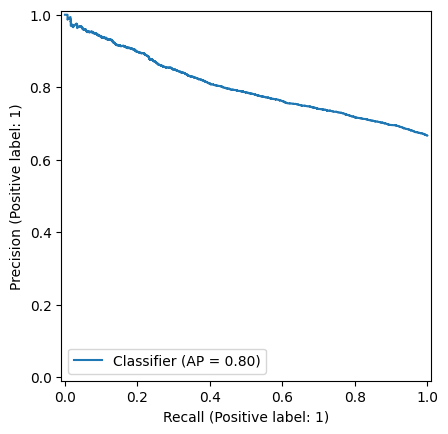

In [37]:
# Cifar10 and subset of Cifar100, max_softmax
PR(scores_test_ms_adv.detach().cpu(), scores_fake2_ms_adv.detach().cpu())

Add comments

### Adversarial attacks
Test if the same attack used to train the network still works.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image and original predicted class


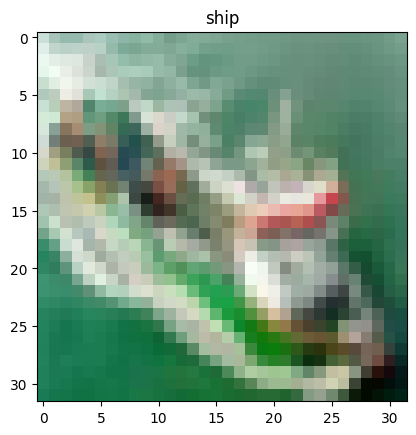

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image and predicted class after the adversarial attack


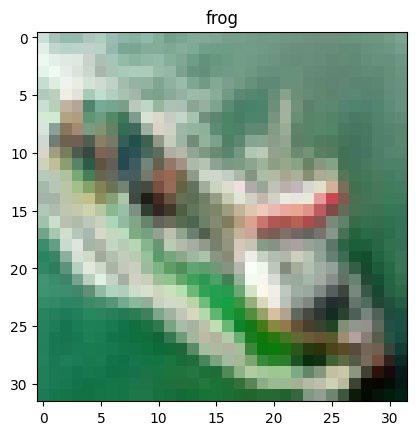

Absolute difference between the two images


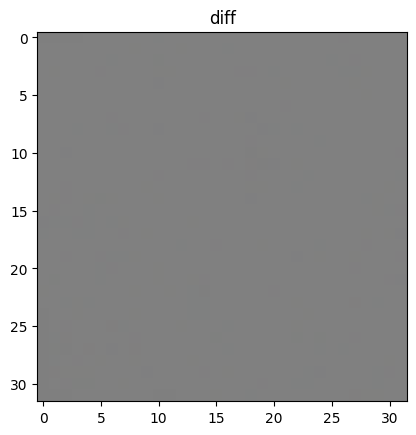

Histogram with the difference of the two images on a pixel level


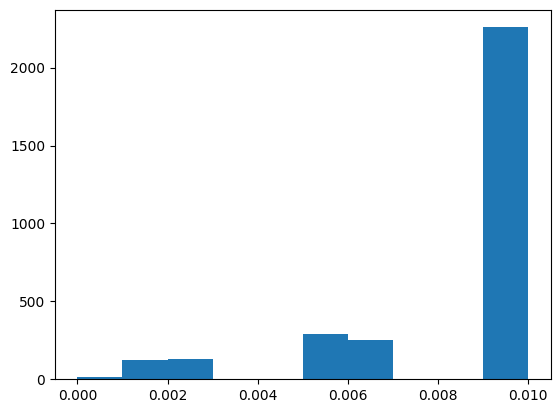

In [38]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Get some test images
for data in dl_test:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model_adv)

# Select a particular image to show the result
id_image=15
# Calculate first output of the model given the real image
first_out = model_adv(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

tensor(0.4548, device='cuda:0')


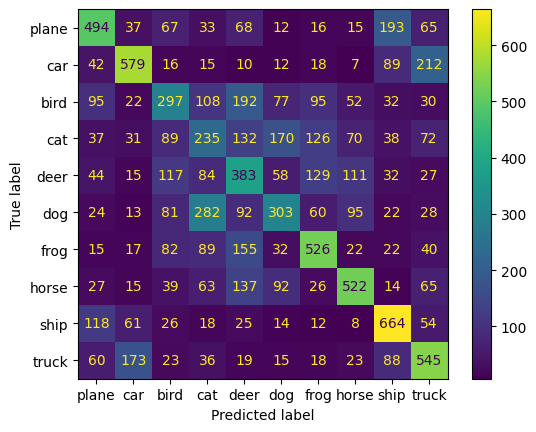

In [39]:
# Test the model on attacked test images
model_adv.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    # Attack the images before feeding them to the model
    x, _ = fgsm.attack(x, y, model_adv)
    x, y = x.to(device), y.to(device)
    
    yp = model_adv(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Add comments

Test the network under a stronger attack.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image and original predicted class


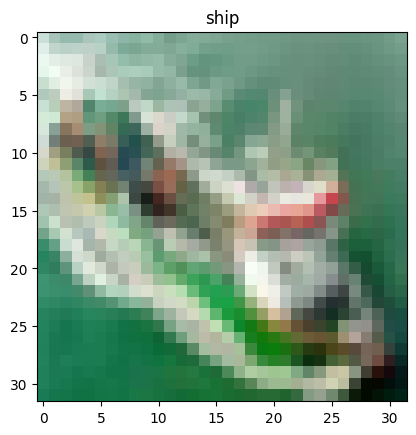

Image and predicted class after the adversarial attack


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


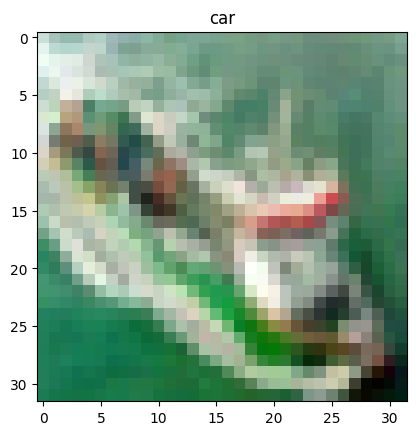

Absolute difference between the two images


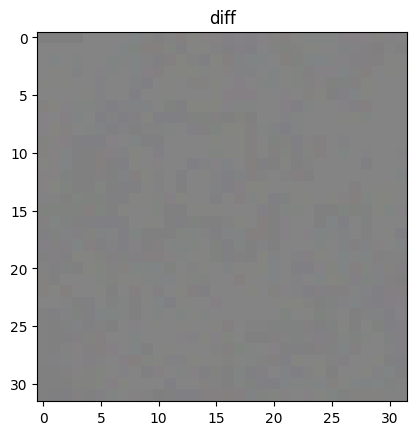

Histogram with the difference of the two images on a pixel level


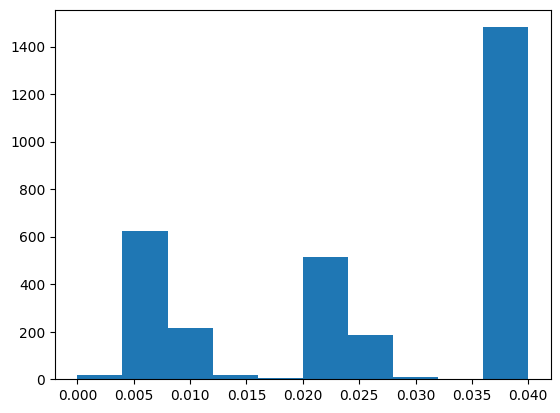

In [40]:
# Bigger epsilon
eps = 0.008

# Get some test images
for data in dl_test:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
adv_images, outputs = fgsm.attack(images, labels, model_adv)

# Select a particular image to show the result
id_image=15
# Calculate first output of the model given the real image
first_out = model_adv(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], adv_images[id_image], outputs[id_image])

tensor(0.1353, device='cuda:0')


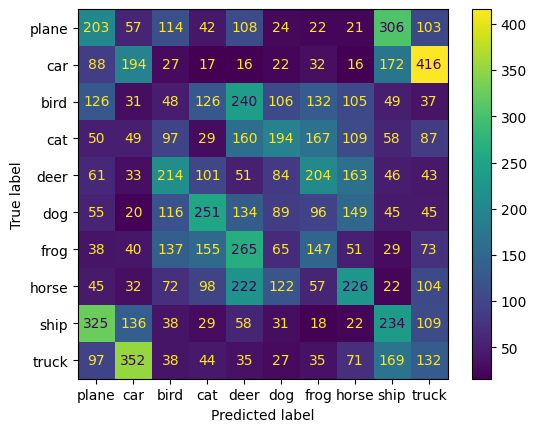

In [41]:
# Test the model on attacked test images
model_adv.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    # Attack the images before feeding them to the model
    x, _ = fgsm.attack(x, y, model_adv)
    x, y = x.to(device), y.to(device)
    
    yp = model_adv(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Add comments

### Adversarial Training with higher epsilon

In [60]:
# Define epsilon, FGSM and model
eps = 0.008
fgsm = FGSM(epsilon = eps, num_steps = 5)
model_adv = CNN().to(device)

# Load pretrained model
model_adv.load_state_dict(torch.load('./cifar10_CNN_adversarial8.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [33]:
# Define epsilon, FGSM and model
eps = 0.008
fgsm = FGSM(epsilon = eps, num_steps = 5)
model_adv = CNN().to(device)

# Train the model from scratch whith adversarial samples
training(model_adv, dl_train, epochs = 50, adversarial =fgsm, name = "_adversarial8")

1 loss: 1.875
2 loss: 1.699
3 loss: 1.635
4 loss: 1.599
5 loss: 1.575
6 loss: 1.554
7 loss: 1.540
8 loss: 1.526
9 loss: 1.515
10 loss: 1.504
11 loss: 1.498
12 loss: 1.490
13 loss: 1.481
14 loss: 1.475
15 loss: 1.468
16 loss: 1.463
17 loss: 1.457
18 loss: 1.453
19 loss: 1.448
20 loss: 1.445
21 loss: 1.442
22 loss: 1.439
23 loss: 1.435
24 loss: 1.433
25 loss: 1.430
26 loss: 1.429
27 loss: 1.426
28 loss: 1.423
29 loss: 1.420
30 loss: 1.419
31 loss: 1.417
32 loss: 1.415
33 loss: 1.411
34 loss: 1.411
35 loss: 1.410
36 loss: 1.408
37 loss: 1.405
38 loss: 1.405
39 loss: 1.403
40 loss: 1.402
41 loss: 1.399
42 loss: 1.397
43 loss: 1.398
44 loss: 1.394
45 loss: 1.394
46 loss: 1.392
47 loss: 1.391
48 loss: 1.390
49 loss: 1.388
50 loss: 1.389
Finished Training


tensor(0.5908, device='cuda:0')


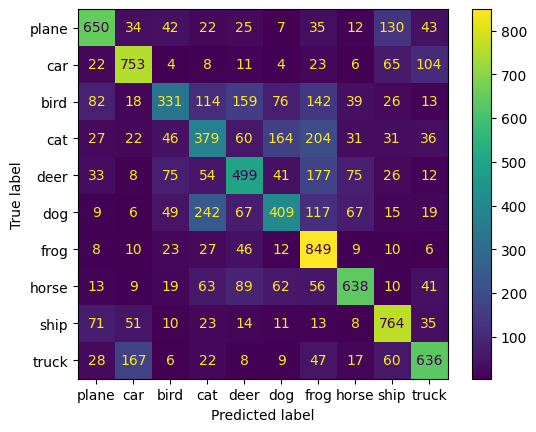

In [61]:
# Test the model on regular test images
model_adv.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    x, y = x.to(device), y.to(device)
    
    yp = model_adv(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Add comments

### Compute scores

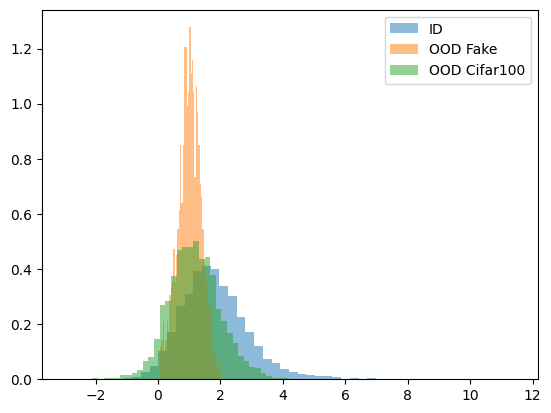

In [62]:
# Scores with max_logit
scores_test_adv = compute_scores(model_adv, dl_test, max_logit)
scores_fake_adv = compute_scores(model_adv, dl_fake, max_logit)
scores_fake2_adv = compute_scores(model_adv, dl_cifar100, max_logit)
_ = plt.hist(scores_test_adv.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_fake2_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

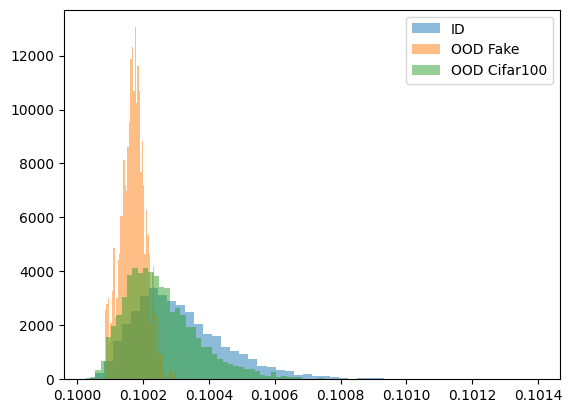

In [63]:
# Scores with max_softmax
temp = 1000
scores_test_ms_adv = compute_scores(model_adv, dl_test, lambda l: max_softmax(l, T=temp))
scores_fake_ms_adv = compute_scores(model_adv, dl_fake, lambda l: max_softmax(l, T=temp))
scores_fake2_ms_adv = compute_scores(model_adv, dl_cifar100, lambda l: max_softmax(l, T=temp))
_ = plt.hist(scores_test_ms_adv.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_ms_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_fake2_ms_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

Add comments

### ROC Curve

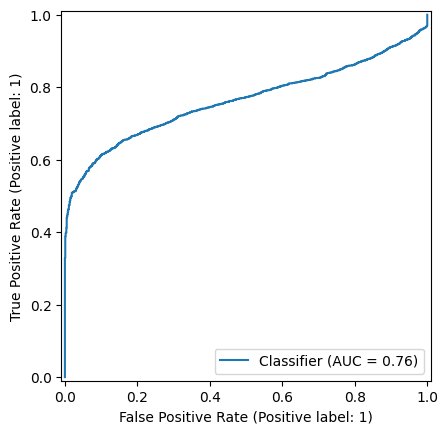

In [65]:
# Cifar10 and FAKE Data, max_logit
ROC(scores_test_adv.detach().cpu(), scores_fake_adv.detach().cpu())

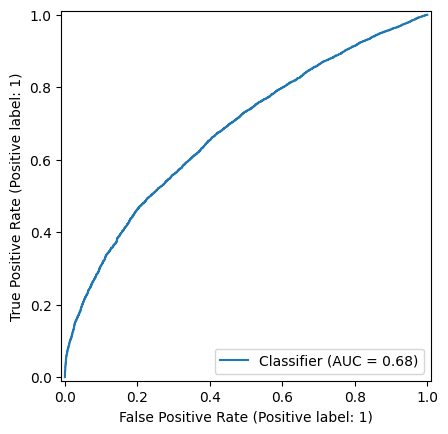

In [67]:
# Cifar10 and subset of Cifar100, max_logit
ROC(scores_test_adv.detach().cpu(), scores_fake2_adv.detach().cpu())

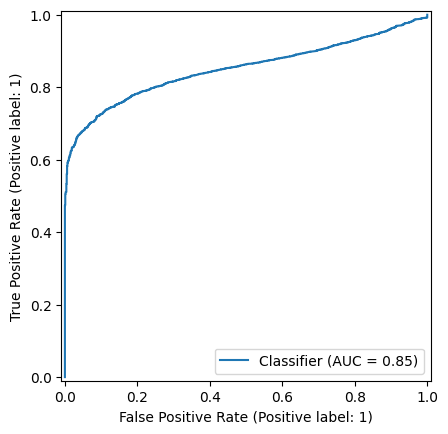

In [68]:
# Cifar10 and FAKE Data, max_softmax
ROC(scores_test_ms_adv.detach().cpu(), scores_fake_ms_adv.detach().cpu())

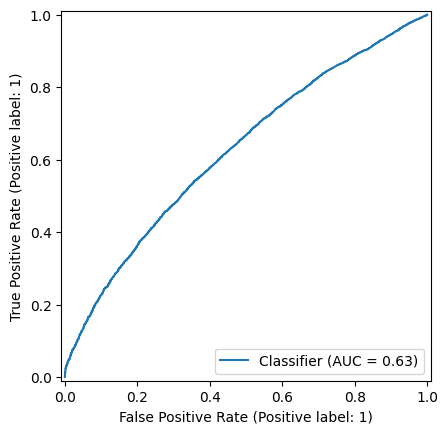

In [70]:
# Cifar10 and subset of Cifar100, max_softmax
ROC(scores_test_ms_adv.detach().cpu(), scores_fake2_ms_adv.detach().cpu())

Add comments

### PR Curve

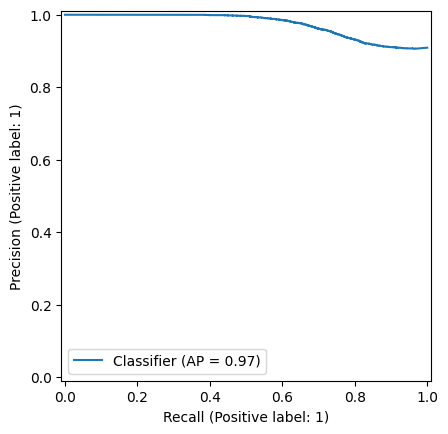

In [71]:
# Cifar10 and FAKE Data, max_logit
PR(scores_test_adv.detach().cpu(), scores_fake_adv.detach().cpu())

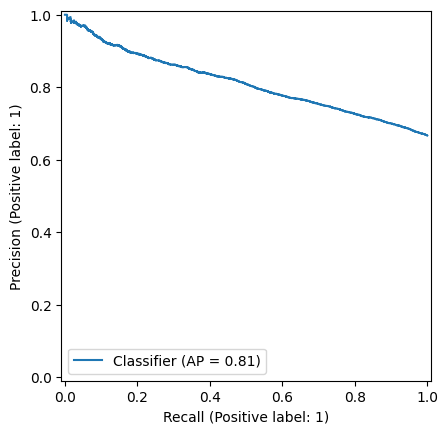

In [72]:
# Cifar10 and subset of Cifar100, max_logit
PR(scores_test_adv.detach().cpu(), scores_fake2_adv.detach().cpu())

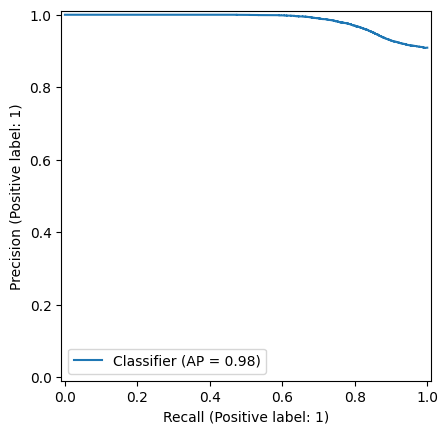

In [73]:
# Cifar10 and FAKE Data, max_softmax
PR(scores_test_ms_adv.detach().cpu(), scores_fake_ms_adv.detach().cpu())

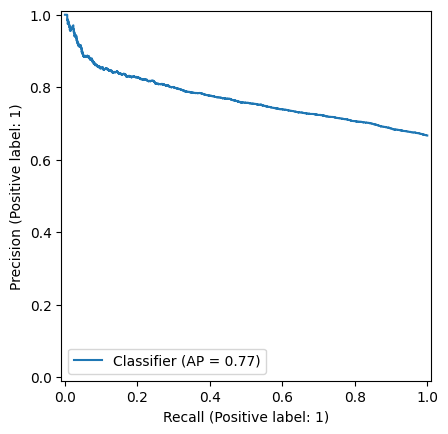

In [74]:
# Cifar10 and subset of Cifar100, max_softmax
PR(scores_test_ms_adv.detach().cpu(), scores_fake2_ms_adv.detach().cpu())

Add comments

### Adversarial Attacks
Test the network under a smaller attack than the one used for training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image and original predicted class


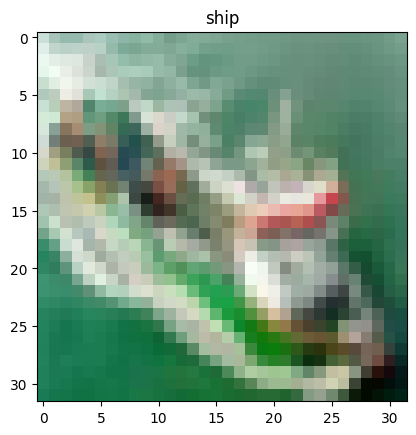

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image and predicted class after the adversarial attack


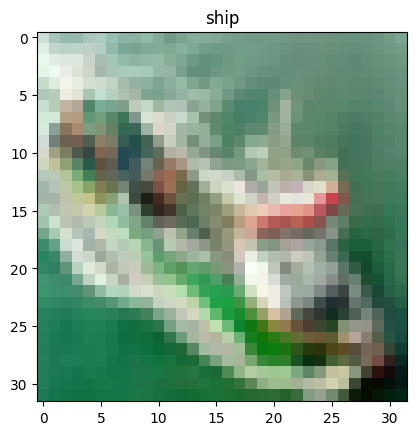

Absolute difference between the two images


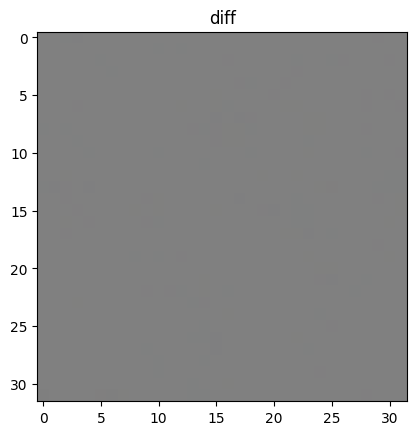

Histogram with the difference of the two images on a pixel level


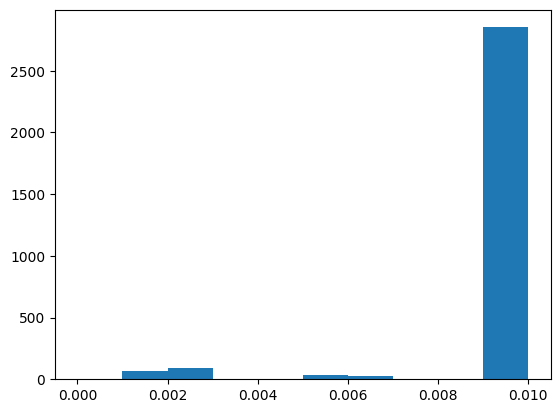

In [76]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Get some test images
for data in dl_test:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model_adv)

# Select a particular image to show the result
id_image=15
# Calculate first output of the model given the real image
first_out = model_adv(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

tensor(0.5151, device='cuda:0')


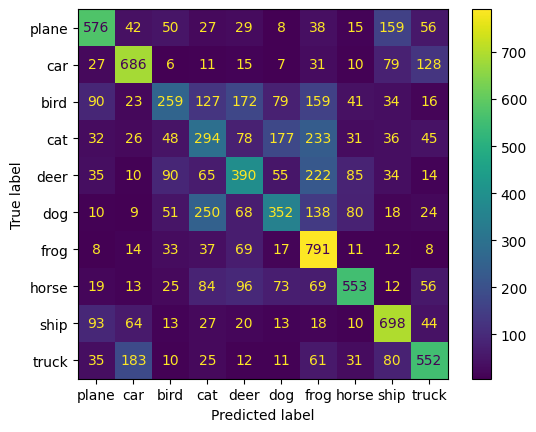

In [77]:
# Test the model on attacked test images
model_adv.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    # Attack the images before feeding them to the model
    x, _ = fgsm.attack(x, y, model_adv)
    x, y = x.to(device), y.to(device)
    
    yp = model_adv(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Add comments

Test the network under the "same" attack used for training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image and original predicted class


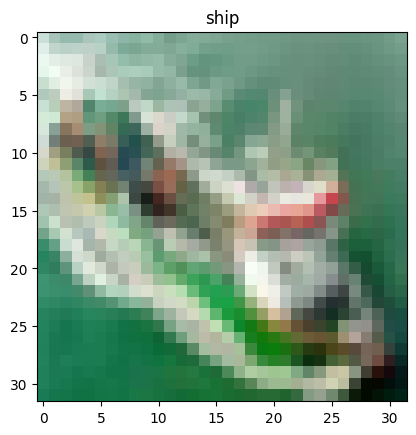

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image and predicted class after the adversarial attack


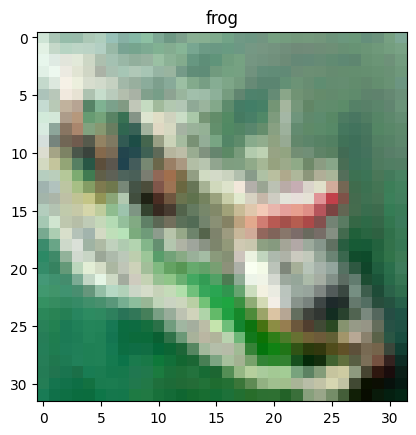

Absolute difference between the two images


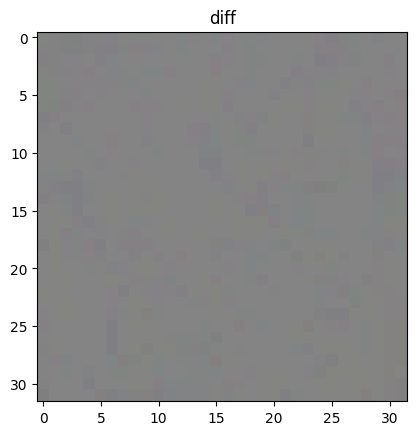

Histogram with the difference of the two images on a pixel level


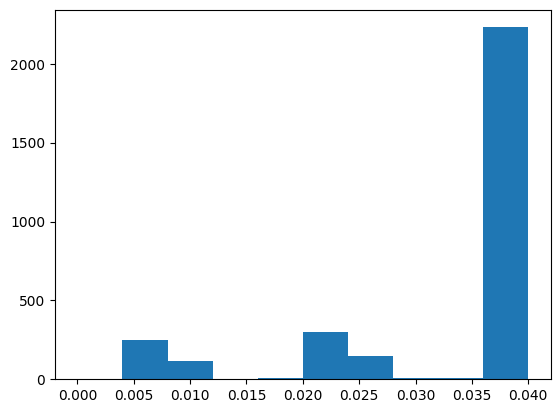

In [78]:
# Bigger epsilon
eps = 0.008

# Get some test images
for data in dl_test:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
adv_images, outputs = fgsm.attack(images, labels, model_adv)

# Select a particular image to show the result
id_image=15
# Calculate first output of the model given the real image
first_out = model_adv(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], adv_images[id_image], outputs[id_image])

tensor(0.3173, device='cuda:0')


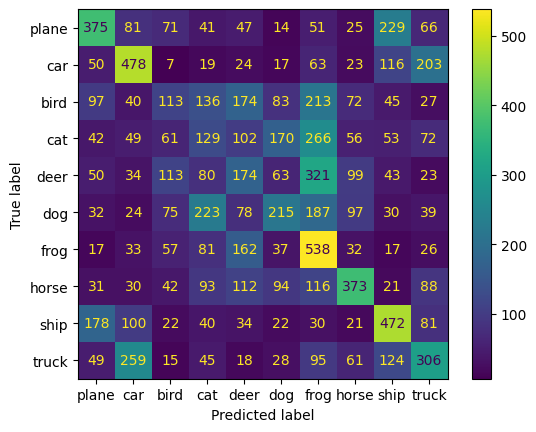

In [79]:
# Test the model on attacked test images
model_adv.eval()
y_gt, y_pred = [], []
for it, data in  enumerate(dl_test):
    x, y = data
    # Attack the images before feeding them to the model
    x, _ = fgsm.attack(x, y, model_adv)
    x, y = x.to(device), y.to(device)
    
    yp = model_adv(x)
    y_pred.append(yp.argmax(1))
    y_gt.append(y)

#print(y_pred.shape)

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_pred_t)
print(accuracy)

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Add comments

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


### Targeted FGSM implementation
Based on the previous implementation of Fast Gradient Sign Method. To implement targeted adversarial attacks, maximize the model probability of $P(Y_{target}|x)$ by modifying the input: $x_{adv} = x - \epsilon * sign(\nabla_xJ(X, Y_{target}))$

In [80]:
#3.3 targeted adversarial attacks

# Implementation of targeted FGSM on a batch of images (with their  real labels and targets) given a model, epsilon and
# the number of steps (how many "adversarial steps" to take)
class Targeted_FGSM:
  def __init__(self, epsilon, num_steps = 5):
    self.epsilon = epsilon
    self.num_steps = num_steps

  def attack(self, images, labels, model, targets):
    model.train()
    # Don't modify original images, labels or targets
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    targets = targets.clone().detach().to(device)

    loss = nn.CrossEntropyLoss()
    # To calculate gradient
    images.requires_grad = True
    for _ in range(self.num_steps):
      # To make grad calculation possible
      images.retain_grad()

      outputs = model(images)
      # Calculate loss with targets, not labels
      cost = loss(outputs, targets)

      # Computes and returns the sum of gradients of outputs with respect to the inputs.
      grad = torch.autograd.grad(cost, images, retain_graph=False)[0]

      # Update adversarial images toward the target classes
      images = images - self.epsilon * grad.sign()
    model.eval()
    return images, outputs

In [81]:
# Same code as before, added targets
# Show the changes between an image before and after the targeted attack
def Compare_img_targeted(image, first_out, adv_image, output,label, target):
  # Show the original image, its predicted and real class
  print(f'Original image and original predicted class')
  img = inv_norm(image)
  plt.imshow(img.permute(1,2,0))
  plt.title(f'Predicted class: {classes[first_out.argmax()]} Real class: {classes[label]}')
  plt.show()

  print(f'Image, predicted class after the adversarial attack and target class')
  # Show the image and its predicted class after the adversarial attack, added target label
  img_adv = inv_norm(adv_image)
  plt.imshow(img_adv.permute(1,2,0).detach().cpu())
  plt.title(f'Predicted class: {classes[output.argmax()]} Target class: {classes[target]}')
  plt.show()

  print(f'Absolute difference between the two images')
  # Computes the absolute value of the difference between the two images and shows it
  diff = torch.abs(adv_image.detach().cpu()-image)
  diff_inv = inv_norm(diff)
  plt.imshow(diff_inv.permute(1,2,0))
  plt.title('diff')
  plt.show()
  print(f'Histogram with the difference of the two images on a pixel level')
  # Show an histogram with the difference between the two images on a pixel level
  diff_flat = diff.flatten()
  plt.hist(diff_flat)

### Testing targeted FGSM
Evaluating the adversarial samples obtained with targeted FGSM attacks and its performances on the CIFAR10 test set.

I chose to implement three different types of targets:

* Hand-selected: define a dictionary that maps original labels to target labels
* Most likely: select the second most likely label predicted by the model as a target for each image
* Least likely: select the least likely label predicted by the model as a target for each image

The testing_targeted function takes a model, a test data loader, an FGSM and a type of target (selected/ second_best / least_likely ), attacks all the test images with the chosen attack and targets and evaluates the FGSM's performance.

It outputs:

* test accuracy of the network before and after the attack and their corresponding confusion matrices
* how many attacks were successful in general (the predicted label of an image after the attack is not the same as the predicted label of the same image before the attack)
* out of all the correctly classified images before the attack: the percentage of images that did not change label after the attack, the percentage of images that did change label after the attack, but that label was not the target and the percentage of images that did change their label to the target after the attack.

In [86]:
import pandas as pd
import seaborn as sn

def testing_targeted(model, test_dataloader, adversarial, target_choice = 'selected'):
  # Test the model
  model.eval()
  # Accumulate all these, described later
  correct = 0
  correct_adv = 0
  attacked = 0
  attacked_correct_targets = 0
  attacked_wrong_targets = 0
  not_attacked = 0
  total = 0
  predictions = []
  predictions_adv = []
  ground_truths = []

  # Dictionary that maps CIFAR10 classes to target classes, only used if target is hand-selected
  dictionary = {'0': 8, '1': 9, '2': 6, '3': 5, '4': 7, '5': 4, '6': 2, '7': 3, '8': 1, '9':0 }

  for data in test_dataloader:
      images, labels = data
      ground_truths.extend(labels.detach().cpu().numpy())
      # Before the attack
      images, labels = images.to(device), labels.to(device)
      logits = model(images)
      _, predicted = torch.max(logits.data, 1)
      predictions.extend(predicted.detach().cpu().numpy())
      # Update the number of all the targets and correct predictions
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      # Select the labels of the correctly predicted images
      labels_correct = labels[predicted-labels == 0].clone()

      # Use hand crafted targets
      if target_choice == 'selected':
        targets = torch.tensor([dictionary[str(x.item())] for x in labels])
      # Use the second most likely label as a target
      if target_choice == 'second_best':
        _, top2 = torch.topk(logits.data,2, 1)
        targets = top2[:,1]
      # Use the least likely label as a target
      if target_choice == 'least_likely':
        _, targets = torch.min(logits.data,1)
      # Attack the images and predict again
      images_adv, _ = adversarial.attack(images, labels, model, targets)
      images_adv, targets = images_adv.to(device), targets.to(device)
      logits_adv = model(images_adv)
      _, predicted_adv = torch.max(logits_adv.data, 1)
      # Collect the predictions after the attack
      predictions_adv.extend(predicted_adv.detach().cpu().numpy())
      # Count correct predictions after the attack
      correct_adv += (predicted_adv == labels).sum().item()
      # Count how many targeted attack where successful in general, predicted label changed
      attacked += (predicted_adv != predicted).sum().item()
      # Select the targets of the correctly predicted images before the attack and their prediction
      targets_correct = targets[predicted - labels == 0].clone()
      predicted_adv_correct = predicted_adv[predicted - labels == 0].clone()
      # Count how many targeted attack where successful starting with a correct prediction
      attacked_correct_targets += (predicted_adv_correct == targets_correct).sum().item()
      # Count how many attacks where successful but the wrong label was chosen starting with a correct prediction
      attacked_wrong_targets += (torch.logical_and(predicted_adv_correct != labels_correct , predicted_adv_correct != targets_correct)).sum().item()
      # Count how many attacks failed, the predicted label did not change
      not_attacked += (predicted_adv_correct == labels_correct).sum().item()

  print(f'Test accuracy of the network before the attack: {100 * correct / total} %')

  # Build and print confusion matrix
  cm = metrics.confusion_matrix(ground_truths, predictions)
  disp = metrics.ConfusionMatrixDisplay(cm, display_labels=classes)
  disp.plot()
  plt.show()

  print(f'Test accuracy of the network after the attack: {100 * correct_adv / total} %')
  print(f'{attacked * 100/total}% attacks were successful in general')
  print(f'Out of the {correct} correctly classified image {np.round(100* not_attacked/correct, 2)}% where not attacked')
  print(f'Out of the {correct} correctly classified image {np.round(100* attacked_wrong_targets/correct, 2)}% where attacked but not with the wanted target')
  print(f'Out of the {correct} correctly classified image {np.round(100* attacked_correct_targets/correct, 2)}% where successfully attacked, classified with the wanted target')

  cm_adv = metrics.confusion_matrix(ground_truths, predictions_adv)
  disp = metrics.ConfusionMatrixDisplay(cm_adv, display_labels=classes)
  disp.plot()
  plt.show()

### Hand-selectd labels
Mapping real labels to target labels using a dictionary

In [93]:
# Get some test images
for data in dl_test:
    images, labels = data
    break
print(f'CIFAR10 classes: {classes}')
# Dictionary that maps CIFAR10 classes to target classes
dictionary = {'0': 2, '1': 4, '2': 9, '3': 8, '4': 1, '5': 3, '6': 5, '7': 6, '8': 0, '9':7 }
# Create targets from labels
targets = torch.tensor([dictionary[str(x.item())] for x in labels])
# Print target of classes
for i in range(len(classes)):
    print(f'Target of {classes[i]} is {classes[dictionary[str(i)]]} ')

CIFAR10 classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Target of plane is bird 
Target of car is deer 
Target of bird is truck 
Target of cat is ship 
Target of deer is car 
Target of dog is cat 
Target of frog is dog 
Target of horse is frog 
Target of ship is plane 
Target of truck is horse 


Original image and original predicted class


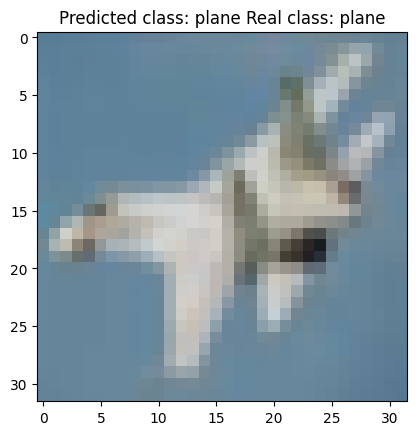

Image, predicted class after the adversarial attack and target class


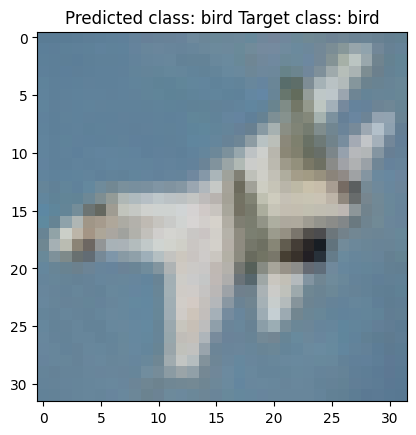

Absolute difference between the two images


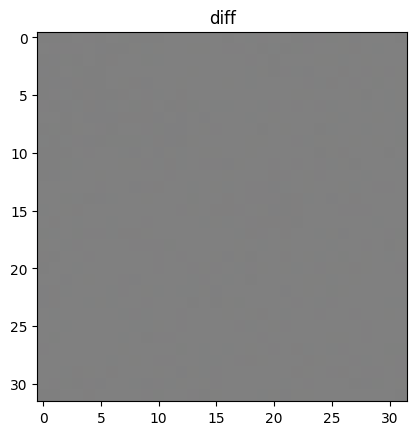

Histogram with the difference of the two images on a pixel level


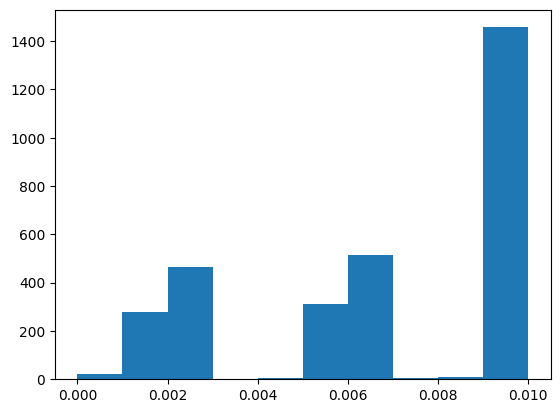

In [94]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Attack the images
fgsm_targeted = Targeted_FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm_targeted.attack(images, labels, model, targets)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img_targeted(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image], labels[id_image], targets[id_image])

Add comments

Test accuracy of the network before the attack: 61.03 %


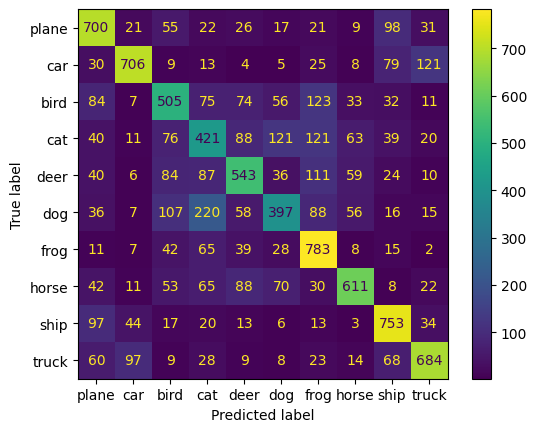

Test accuracy of the network after the attack: 38.35 %
48.86% attacks were successful in general
Out of the 6103 correctly classified image 56.5% where not attacked
Out of the 6103 correctly classified image 10.11% where attacked but not with the wanted target
Out of the 6103 correctly classified image 33.39% where successfully attacked, classified with the wanted target


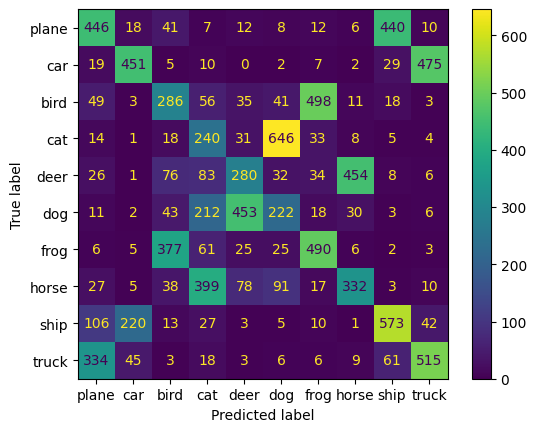

In [95]:
testing_targeted(model, dl_test, fgsm_targeted, 'selected')

Add comments

### Most likely class as target
After the model first prediction (before the attack) select the second most likely label as the target.

Original image and original predicted class


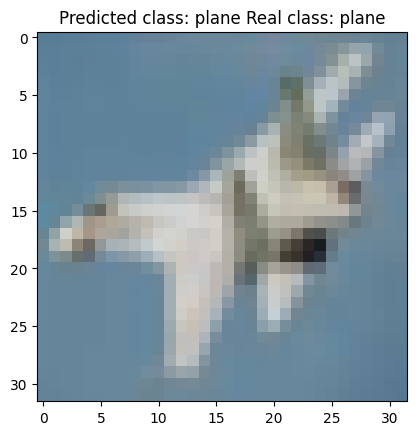

Image, predicted class after the adversarial attack and target class


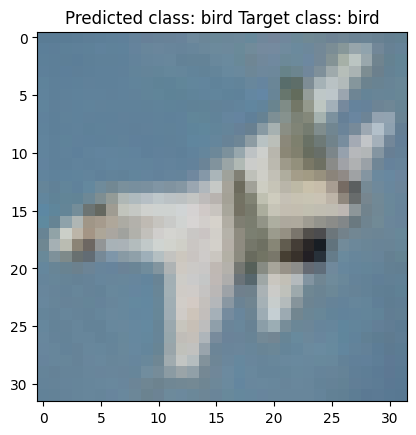

Absolute difference between the two images


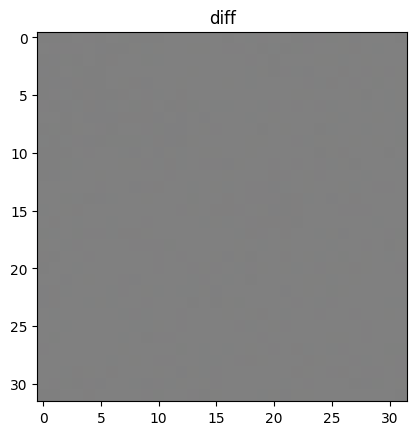

Histogram with the difference of the two images on a pixel level


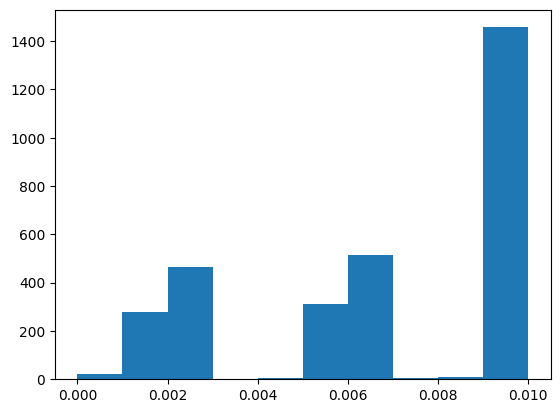

In [96]:
# Get some test images
for data in dl_test:
    images, labels = data
    break

# Predict the label given to the image
images = images.to(device)
logits = model(images)

# Select the top 2 most probable classes
_, top2 = torch.topk(logits.data,2, 1)
# Use the second most likely label as a target
second_best = top2[:,1]

# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Attack the images
fgsm_targeted = Targeted_FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm_targeted.attack(images, labels, model, second_best)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images)
images = images.cpu()
# Print image, compare the assiged label before and after the attack
Compare_img_targeted(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image], labels[id_image], second_best[id_image])

Add comments

Test accuracy of the network before the attack: 61.03 %


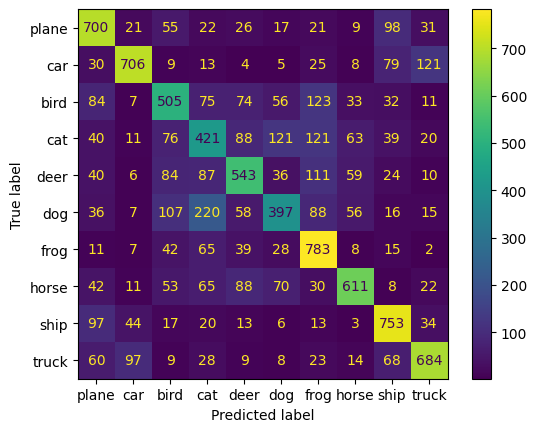

Test accuracy of the network after the attack: 36.66 %
76.86% attacks were successful in general
Out of the 6103 correctly classified image 34.47% where not attacked
Out of the 6103 correctly classified image 0.23% where attacked but not with the wanted target
Out of the 6103 correctly classified image 65.3% where successfully attacked, classified with the wanted target


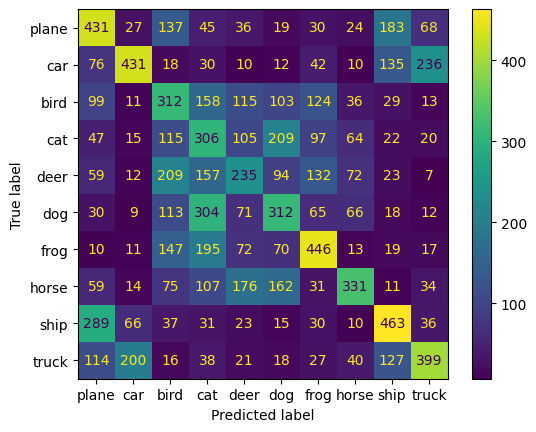

In [97]:
testing_targeted(model, dl_test, fgsm_targeted, 'second_best')

Add comments

### Least likely class as target
After the model first prediction (before the attack) select the least likely label as the target.

Original image and original predicted class


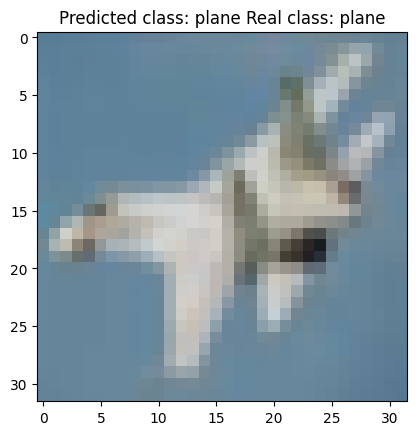

Image, predicted class after the adversarial attack and target class


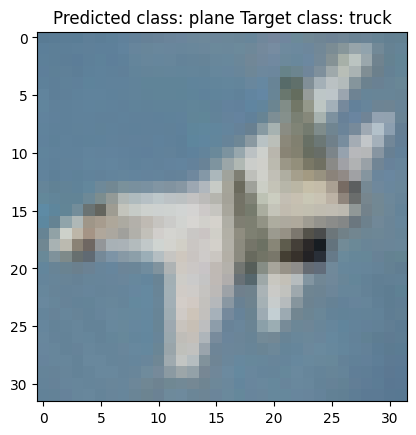

Absolute difference between the two images


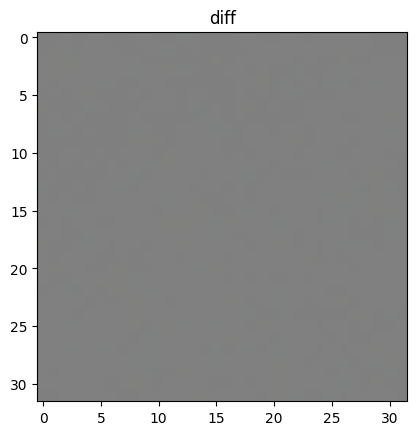

Histogram with the difference of the two images on a pixel level


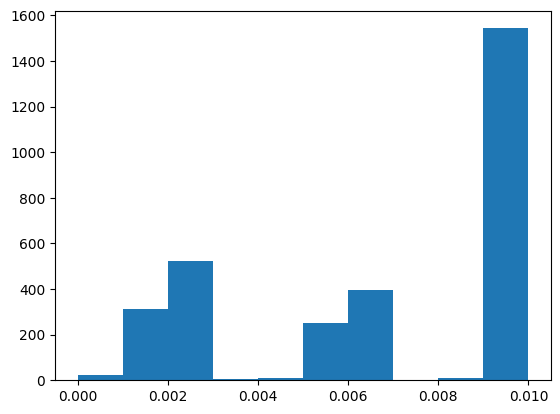

In [98]:
# Get some test images
for data in dl_test:
    images, labels = data
    break

# Predict the label given to the image
images = images.to(device)
logits = model(images)

# Use the least likely class as target
_, least_likely = torch.min(logits.data, 1)

# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Attack the images
fgsm_targeted = Targeted_FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm_targeted.attack(images, labels, model, least_likely)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images)
images = images.cpu()
# Print image, compare the assiged label before and after the attack
Compare_img_targeted(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image], labels[id_image], least_likely[id_image])

Add comments

Test accuracy of the network before the attack: 61.03 %


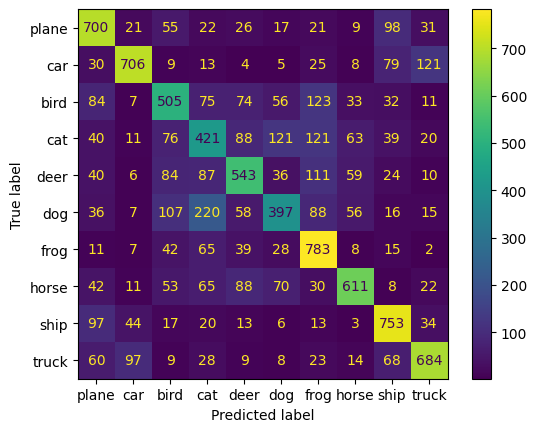

Test accuracy of the network after the attack: 52.49 %
35.5% attacks were successful in general
Out of the 6103 correctly classified image 74.8% where not attacked
Out of the 6103 correctly classified image 24.09% where attacked but not with the wanted target
Out of the 6103 correctly classified image 1.11% where successfully attacked, classified with the wanted target


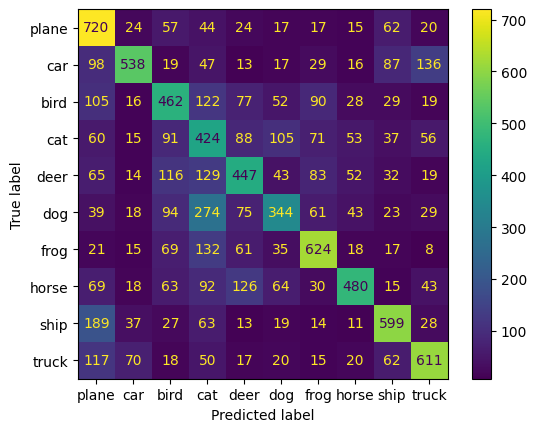

In [99]:
testing_targeted(model, dl_test, fgsm_targeted, 'least_likely')

Add comments